# Data Preprocessing

This notebook contains data preprocessing steps, including exploration, data cleaning, and feature generation.

Input: Kaggle World Cities Dataset, loaded from data/raw/worldcitiespop.csv

Output: Preprocessed Dataset, saved into data/processed/world_cities_processed.csv

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_RAW = Path("../data/raw/worldcitiespop.csv")
DATA_PROC = Path("../data/processed")
DATA_PROC.mkdir(parents=True, exist_ok=True)

In [51]:
df = pd.read_csv(DATA_RAW)

C:\Users\Alex\AppData\Local\Temp\ipykernel_31604\3183141574.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_RAW)


## Exploration

In [52]:
print("Initial Data Shape:", df.shape)
df.head()

Initial Data Shape: (3173958, 7)


,Country,City,AccentCity,Region,Population,Latitude,Longitude
0,ad,aixas,Aixàs,6.0,NaN,42.483333,1.466667
1,ad,aixirivali,Aixirivali,6.0,NaN,42.466667,1.500000
2,ad,aixirivall,Aixirivall,6.0,NaN,42.466667,1.500000
3,ad,aixirvall,Aixirvall,6.0,NaN,42.466667,1.500000
4,ad,aixovall,Aixovall,6.0,NaN,42.466667,1.483333


In [53]:
df.describe()

,Population,Latitude,Longitude
count,4.798000e+04,3.173958e+06,3.173958e+06
mean,4.771957e+04,2.718817e+01,3.708886e+01
std,3.028887e+05,2.195262e+01,6.322302e+01
min,7.000000e+00,-5.493333e+01,-1.799833e+02
25%,3.732000e+03,1.163333e+01,7.303176e+00
50%,1.077900e+04,3.249722e+01,3.528000e+01
75%,2.799050e+04,4.371667e+01,9.570354e+01
max,3.148050e+07,8.248333e+01,1.800000e+02


In [54]:
df.describe(include='all')

,Country,City,AccentCity,Region,Population,Latitude,Longitude
count,3173958,3173952,3173954,3173950.0,4.798000e+04,3.173958e+06,3.173958e+06
unique,234,2351891,2375759,490.0,NaN,NaN,NaN
top,cn,san jose,San Antonio,7.0,NaN,NaN,NaN
freq,238985,328,317,93917.0,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,4.771957e+04,2.718817e+01,3.708886e+01
std,NaN,NaN,NaN,NaN,3.028887e+05,2.195262e+01,6.322302e+01
min,NaN,NaN,NaN,NaN,7.000000e+00,-5.493333e+01,-1.799833e+02
25%,NaN,NaN,NaN,NaN,3.732000e+03,1.163333e+01,7.303176e+00
50%,NaN,NaN,NaN,NaN,1.077900e+04,3.249722e+01,3.528000e+01
75%,NaN,NaN,NaN,NaN,2.799050e+04,4.371667e+01,9.570354e+01


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173958 entries, 0 to 3173957
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Country     object 
 1   City        object 
 2   AccentCity  object 
 3   Region      object 
 4   Population  float64
 5   Latitude    float64
 6   Longitude   float64
dtypes: float64(3), object(4)
memory usage: 169.5+ MB


In [56]:
df.isna().sum()

Country             0
City                6
AccentCity          4
Region              8
Population    3125978
Latitude            0
Longitude           0
dtype: int64

We can see that the data contains duplicates and NaN values

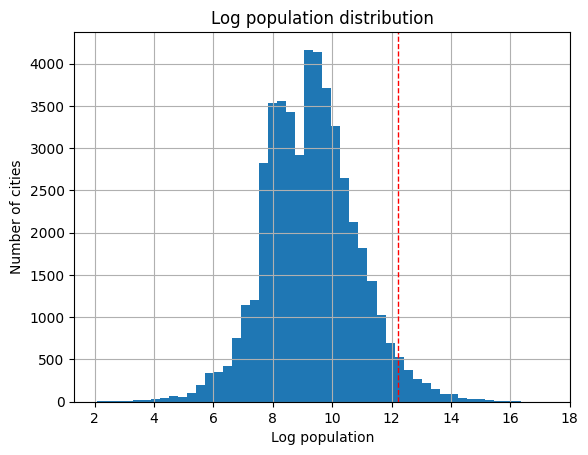

In [57]:
df['Population'].dropna().apply(np.log1p).hist(bins=50)
plt.axvline(np.log1p(200000), color='red', linestyle='dashed', linewidth=1)
plt.xlabel("Log population")
plt.ylabel("Number of cities")
plt.title("Log population distribution")
plt.show()

We can see that most cities have populations significantly lower than 200000

## Preprocessing

### Data Filtering
Unfortunately, the complete dataset is too large to run on my hardware or on a free google Colab plan. The distance matrix used to find the nearest neighbors is ~200000x200000. Changing the nearest neighbors algorithm to only search in the nearest vicinity of the city also crashed due to and Out-of-Memory error.

So, it was needed to filter it and only use a subset of the data

I decided to use the task definition for the data filtering:

```Consider the World Cities dataset describing some of the world's major(!) cities```

Now, let's switch approach and define "major" cities. Let's start simple. A "major" city for this task is a city which has a population of >= 5000

In [58]:
df = df.rename(columns={
    'Country': 'country',
    'City': 'city',
    'AccentCity': 'accent_city',
    'Region': 'region',
    'Latitude': 'lat',
    'Longitude': 'lon',
    'Population': 'population'
})

In [59]:
# Drop NaN values in critical columns
df = df.dropna(subset=['city', 'accent_city', 'lat', 'lon'])
# df = df.dropna(subset=['population'])

# lowercase country and city names
df['country'] = df['country'].str.strip().str.lower()
df['city'] = df['city'].str.strip().str.lower()
df['accent_city'] = df['accent_city'].str.strip().str.lower()

In [60]:
# Drop Duplicates keeping the entry with the highest population
df = df.sort_values('population', ascending=False)
# df = df.drop_duplicates(subset=['country'], keep='first')
df = df.drop_duplicates(subset=['city'], keep='first')
df = df.drop_duplicates(subset=['accent_city'], keep='first')
df = df.drop_duplicates(subset=['lat', 'lon'], keep='first')
df.loc[df['city']=='london', 'lon'] = 0.29
df = df[df['population'] >= 5000]

In [61]:
df.shape

(29994, 7)

In [62]:
df.head()

,country,city,accent_city,region,population,lat,lon
1544449,jp,tokyo,tokyo,40,31480498.0,35.685000,139.751389
570824,cn,shanghai,shanghai,23,14608512.0,31.045556,121.399722
1327914,in,bombay,bombay,16.0,12692717.0,18.975000,72.825833
2200161,pk,karachi,karachi,05,11627378.0,24.905600,67.082200
1331162,in,delhi,delhi,7.0,10928270.0,28.666667,77.216667


## Feature Engineering

For now, we just engineer a single feature that indicates if the city has more than 200000 population

In [63]:
df['has_large_population'] = df['population'].fillna(0) > 200000

In [64]:
df

,country,city,accent_city,region,population,lat,lon,has_large_population
1544449,jp,tokyo,tokyo,40,31480498.0,35.685000,139.751389,True
570824,cn,shanghai,shanghai,23,14608512.0,31.045556,121.399722,True
1327914,in,bombay,bombay,16.0,12692717.0,18.975000,72.825833,True
2200161,pk,karachi,karachi,05,11627378.0,24.905600,67.082200,True
1331162,in,delhi,delhi,7.0,10928270.0,28.666667,77.216667,True
...,...,...,...,...,...,...,...,...
346458,ca,antigonish,antigonish,7,5003.0,45.616667,-61.966667,False
2384798,ru,chemodanovka,chemodanovka,57,5002.0,53.231621,45.247377,False
2541769,ru,tuzha,tuzha,33,5002.0,57.606149,47.935974,False
2333130,ro,piscu,piscu,18,5002.0,45.500000,27.733333,False


In [65]:
# Save the processed data
df.to_csv(DATA_PROC / "worldcities_processed_major.csv", index=False)
print("Processed data saved to", DATA_PROC / "worldcities_processed.csv")

Processed data saved to ..\data\processed\worldcities_processed.csv


## Draw the cities on a world map to inspect them visually

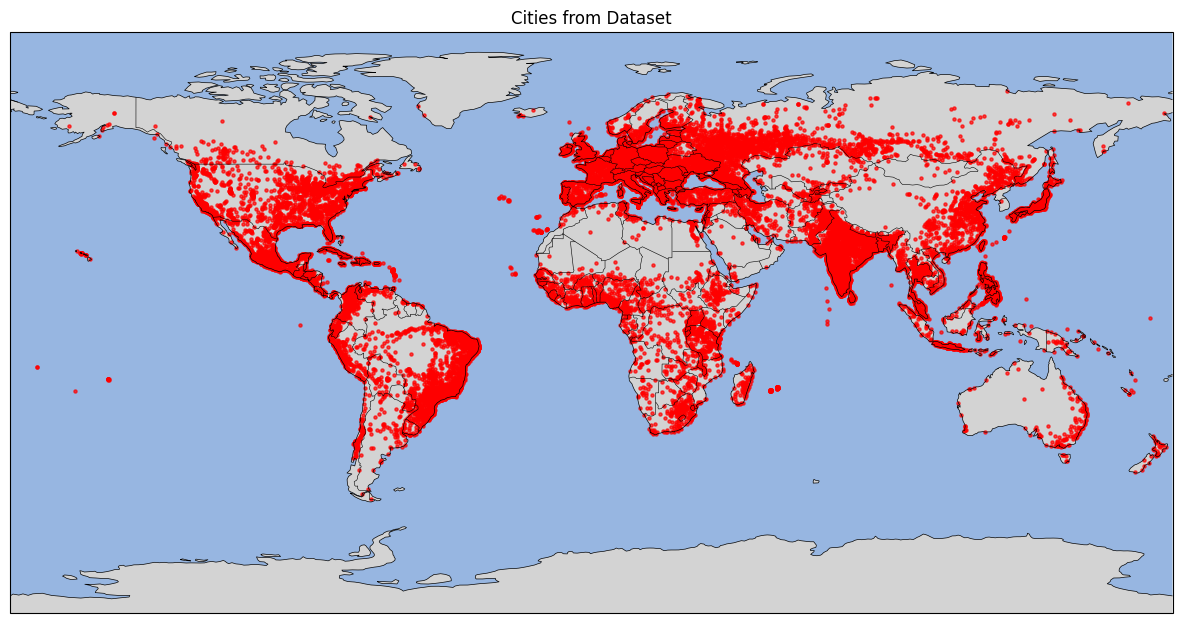

In [52]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(15, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)

# Plot cities
ax.scatter(
    df['lon'], 
    df['lat'],
    s=5,
    color='red',
    alpha=0.7,
    transform=ccrs.PlateCarree()
)

plt.title("Cities from Dataset")
plt.show()

In [18]:
df_uk = df[df['country'] == 'gb']

In [30]:
import numpy as np
import networkx as nx
from sklearn.neighbors import BallTree

# df has columns:
# ['country', 'city', 'accent_city', 'region', 'population', 'lat', 'lon', 'has_large_population']

# Convert degrees → radians (required for haversine metric)
coords_rad = np.radians(df[['lat', 'lon']].to_numpy())

# Build BallTree
tree = BallTree(coords_rad, metric='haversine')

# Query: find each point's 4 NN (self + 3 neighbors)
distances, indices = tree.query(coords_rad, k=500)

In [ ]:
df = df.reset_index(drop=True)
G = nx.DiGraph()

# Add nodes with attributes
for i, row in df.iterrows():
    G.add_node(
        i, 
        city=row["city"],
        country=row["country"],
        lat=row["lat"],
        lon=row["lon"],
        population=row["population"]
    )

# Add directed edges
earth_radius_km = 6371

def is_eastward(lon_from, lon_to):
    """Return True if lon_to is east of lon_from considering wrap-around."""
    delta = (lon_to - lon_from + 360) % 360
    return 0 < delta < 180

for city_idx, (nbrs, dists) in enumerate(zip(indices, distances)):
    city_lon = df.loc[city_idx, "lon"]
    
    eastward_edges = []
    for n_idx, dist in zip(nbrs[1:], dists[1:]):  # skip self
        neighbor_lon = df.loc[n_idx, "lon"]
        if is_eastward(city_lon, neighbor_lon):
            eastward_edges.append((n_idx, dist * earth_radius_km))
        if len(eastward_edges) == 3:
            break
    
    for n_idx, dist_km in eastward_edges:
        G.add_edge(city_idx, n_idx, distance_km=float(dist_km))


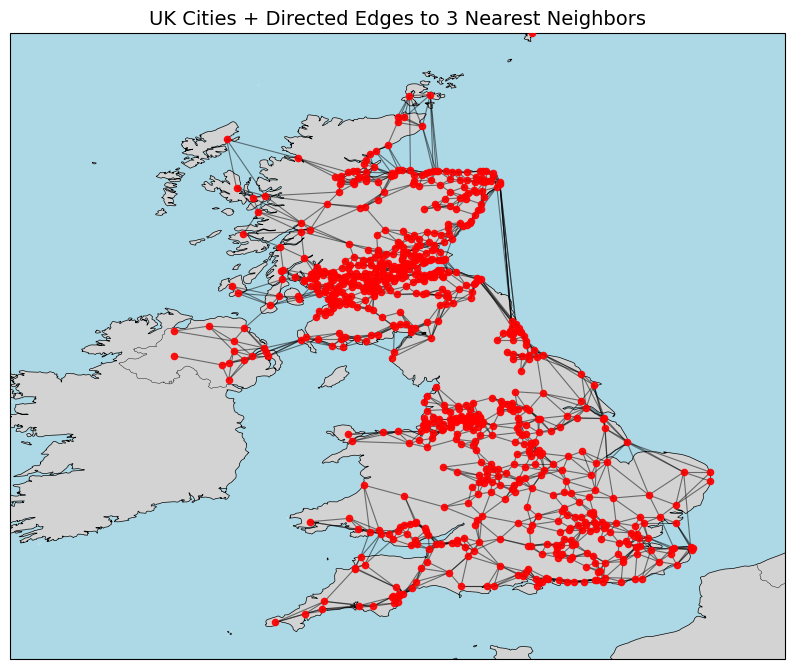

In [32]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Filter only UK cities (adjust country code as needed)
uk = df[df["country"].str.lower().isin(["gb", "uk"])]
uk_idx = set(uk.index)

# Choose projection (PlateCarree works for UK bounding box)
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=proj)

# Set bounding box roughly covering UK
ax.set_extent([-10, 3, 49.5, 60], crs=proj)

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Plot UK cities
ax.scatter(
    uk["lon"], uk["lat"],
    s=20, color='red', alpha=0.9,
    transform=proj,
    zorder=5
)

# Plot edges: only edges where both ends are in UK
for u, v in G.edges():
    if u in uk_idx and v in uk_idx:
        lon1, lat1 = df.loc[u, ["lon", "lat"]]
        lon2, lat2 = df.loc[v, ["lon", "lat"]]
        plt.plot([lon1, lon2], [lat1, lat2],
                 color='black', linewidth=0.8,
                 alpha=0.5,
                 transform=proj,
                 zorder=4)

plt.title("UK Cities + Directed Edges to 3 Nearest Neighbors", fontsize=14)
plt.show()


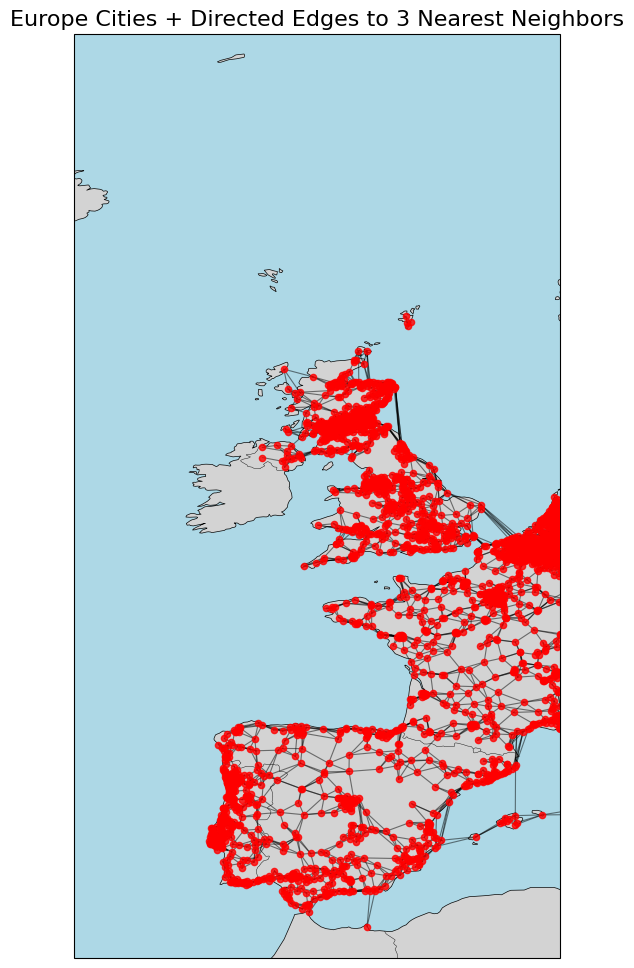

In [33]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Define European country codes (ISO alpha-2)
europe_codes = [
    "gb", "fr", "de", "it", "es", "pt", "nl", "be", "lu"
]

# Filter only European cities
europe = df[df["country"].str.lower().isin(europe_codes)]
europe_idx = set(europe.index)

# Choose projection
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(14, 12))
ax = plt.axes(projection=proj)

# Set bounding box roughly covering Europe
ax.set_extent([-15, 5, 34, 72], crs=proj)

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Plot European cities
ax.scatter(
    europe["lon"], europe["lat"],
    s=20, color='red', alpha=0.8,
    transform=proj,
    zorder=5
)

# Plot edges: only edges where both ends are in Europe
for u, v in G.edges():
    if u in europe_idx and v in europe_idx:
        lon1, lat1 = df.loc[u, ["lon", "lat"]]
        lon2, lat2 = df.loc[v, ["lon", "lat"]]
        plt.plot([lon1, lon2], [lat1, lat2],
                 color='black', linewidth=0.8,
                 alpha=0.5,
                 transform=proj,
                 zorder=4)

plt.title("Europe Cities + Directed Edges to 3 Nearest Neighbors", fontsize=16)
plt.show()


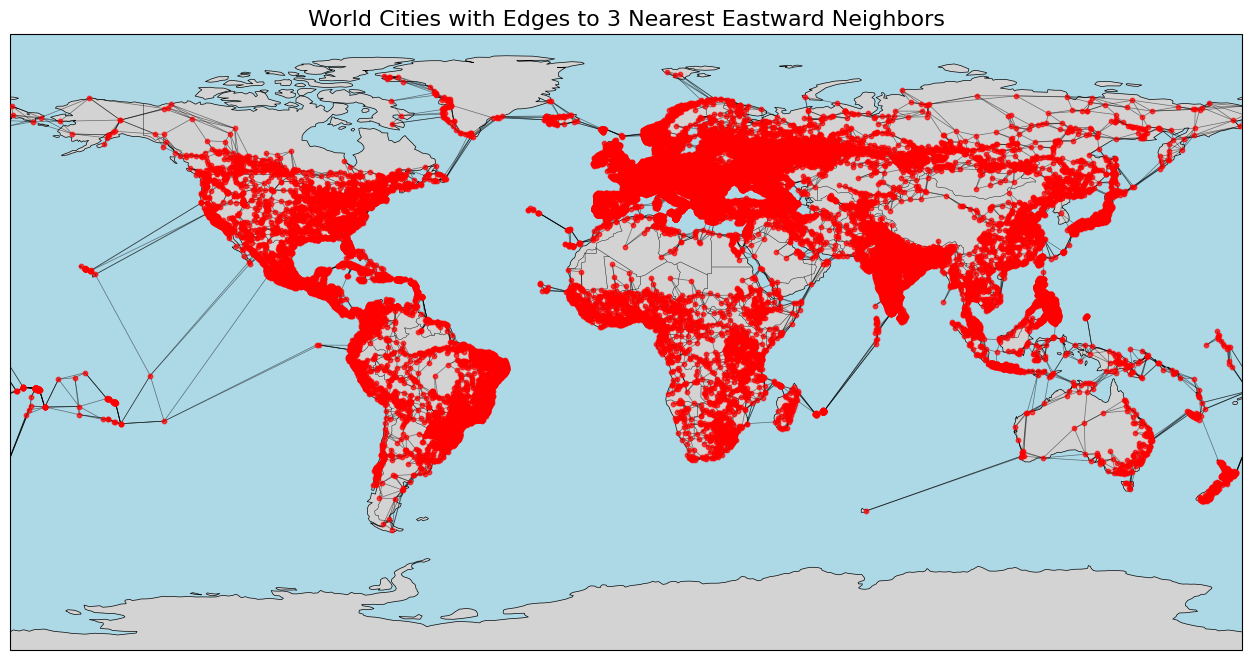

In [34]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Choose projection
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=proj)

# Set global extent
ax.set_global()

# Add map features
ax.add_feature(cfeature.LAND, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.3)

# Plot all cities
ax.scatter(
    df["lon"], df["lat"],
    s=10, color='red', alpha=0.7,
    transform=proj,
    zorder=5
)

# Plot eastward edges
for u, v in G.edges():
    lon1, lat1 = df.loc[u, ["lon", "lat"]]
    lon2, lat2 = df.loc[v, ["lon", "lat"]]
    
    # Optional: handle dateline crossing for nicer lines
    if abs(lon2 - lon1) > 180:
        if lon1 < 0:
            lon1 += 360
        else:
            lon2 += 360
    
    ax.plot([lon1, lon2], [lat1, lat2],
            color='black', linewidth=0.5,
            alpha=0.5,
            transform=proj,
            zorder=4)

plt.title("World Cities with Edges to 3 Nearest Eastward Neighbors", fontsize=16)
plt.show()
